## Problem Statement

### Business Context

The healthcare industry is rapidly evolving, with professionals facing increasing challenges in managing vast volumes of medical data while delivering accurate and timely diagnoses. The need for quick access to comprehensive, reliable, and up-to-date medical knowledge is critical for improving patient outcomes and ensuring informed decision-making in a fast-paced environment.

Healthcare professionals often encounter information overload, struggling to sift through extensive research and data to create accurate diagnoses and treatment plans. This challenge is amplified by the need for efficiency, particularly in emergencies, where time-sensitive decisions are vital. Furthermore, access to trusted, current medical information from renowned manuals and research papers is essential for maintaining high standards of care.

To address these challenges, healthcare centers can focus on integrating systems that streamline access to medical knowledge, provide tools to support quick decision-making, and enhance efficiency. Leveraging centralized knowledge platforms and ensuring healthcare providers have continuous access to reliable resources can significantly improve patient care and operational effectiveness.

**Common Questions to Answer**

**1. Diagnostic Assistance**: "What are the common symptoms and treatments for pulmonary embolism?"

**2. Drug Information**: "Can you provide the trade names of medications used for treating hypertension?"

**3. Treatment Plans**: "What are the first-line options and alternatives for managing rheumatoid arthritis?"

**4. Specialty Knowledge**: "What are the diagnostic steps for suspected endocrine disorders?"

**5. Critical Care Protocols**: "What is the protocol for managing sepsis in a critical care unit?"

### Objective

As an AI specialist, your task is to develop a RAG-based AI solution using renowned medical manuals to address healthcare challenges. The objective is to **understand** issues like information overload, **apply** AI techniques to streamline decision-making, **analyze** its impact on diagnostics and patient outcomes, **evaluate** its potential to standardize care practices, and **create** a functional prototype demonstrating its feasibility and effectiveness.

### Data Description

The **Merck Manuals** are medical references published by the American pharmaceutical company Merck & Co., that cover a wide range of medical topics, including disorders, tests, diagnoses, and drugs. The manuals have been published since 1899, when Merck & Co. was still a subsidiary of the German company Merck.

The manual is provided as a PDF with over 4,000 pages divided into 23 sections.

## Installing and Importing Necessary Libraries and Dependencies

In [1]:
!pip install pandas==2.2.2

In [5]:
!pip install numpy==1.26.0

In [6]:
!pip install huggingface_hub==0.30.2

In [7]:
# Installation for GPU llama-cpp-python
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.2.28 --force-reinstall --upgrade --no-cache-dir -q 2>/dev/null

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 109.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 152.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 254.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 157.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 281.9 MB/s eta 0:00:00


In [8]:
# For installing the libraries & downloading models from HF Hub
!pip install tiktoken==0.6.0 pymupdf==1.25.1 langchain==0.1.1 langchain-community==0.0.13 chromadb==0.4.22 sentence-transformers==2.3.1 thinc==8.2.5 spacy==3.7.6

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.5
    Uninstalling numpy-2.2.5:
      Successfully uninstalled numpy-2.2.5


In [9]:
#Libraries for processing dataframes,text
import json,os
import tiktoken
import pandas as pd

#Libraries for Loading Data, Chunking, Embedding, and Vector Databases
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain_community.vectorstores import Chroma

#Libraries for downloading and loading the llm
from huggingface_hub import hf_hub_download
from llama_cpp import Llama

## Question Answering using LLM

#### Downloading and Loading the model

In [10]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GGUF"
model_basename = "llama-2-13b-chat.Q5_K_M.gguf" # the model is in gguf format

In [11]:
# Using hf_hub_download to download a model from the Hugging Face model hub
# The repo_id parameter specifies the model name or path in the Hugging Face repository
# The filename parameter specifies the name of the file to download
model_path = hf_hub_download(
    repo_id=model_name_or_path,
    filename=model_basename
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


llama-2-13b-chat.Q5_K_M.gguf:   0%|          | 0.00/9.23G [00:00<?, ?B/s]

In [12]:
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2,  # CPU cores
    n_batch=512,  # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=43,  # Change this value based on your model and your GPU VRAM pool.
    n_ctx=4096,  # Context window
)

AVX = 1 | AVX_VNNI = 0 | AVX2 = 1 | AVX512 = 1 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 


#### Response Function

In [109]:
def response(query,max_tokens=128,temperature=0,top_p=0.95,top_k=50):
    model_output = lcpp_llm(
      prompt=query,
      max_tokens=max_tokens,
      temperature=temperature,
      top_p=top_p,
      top_k=top_k
    )

    return model_output['choices'][0]['text']

### Query 1: What is the protocol for managing sepsis in a critical care unit?

In [108]:
user_prompt_sepsis_no_gen = "What is the protocol for managing sepsis in a critical care unit?"
response = response(user_prompt_sepsis_no_gen)
print(response)

Llama.generate: prefix-match hit



Sepsis is a life-threatening condition that can arise from an infection, and it is a leading cause of death in hospitals. The management of sepsis in a critical care unit requires a protocol that includes early recognition, prompt treatment, and ongoing monitoring. Here are the key components of a sepsis protocol for managing patients in a critical care unit:

1. Early recognition: Sepsis can be difficult to diagnose, but it is essential to identify patients who are at risk of developing sepsis early. The protocol should include a systematic assessment of patients


### Query 2: What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?

In [110]:
user_prompt_appendicitis_no_gen = "What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?"
response = response(user_prompt_appendicitis_no_gen)
print(response)

Llama.generate: prefix-match hit




Answer:

Appendicitis is a medical emergency that requires prompt treatment. The common symptoms of appendicitis include:

1. Severe pain in the abdomen, usually starting near the belly button and then moving to the lower right side of the abdomen.
2. Nausea and vomiting.
3. Loss of appetite.
4. Fever.
5. Abdominal tenderness and guarding (muscle tension).
6. Abdominal swelling.
7. Diarrhea or constipation.


### Query 3: What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?

In [21]:
user_prompt_hairloss_no_gen = "What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?"
response = response(user_prompt_hairloss_no_gen)
print(response)

Llama.generate: prefix-match hit



Sudden patchy hair loss, also known as alopecia areata, can be caused by a variety of factors. Here are some effective treatments and solutions for addressing this condition:

1. Corticosteroid injections: These injections can help suppress the immune system and promote hair growth. They are usually given every 4-6 weeks and can be effective in promoting hair regrowth.
2. Topical corticosteroids: Over-the-counter or prescription topical corticosteroids can be applied directly to the affected area to reduce inflamm


### Query 4:  What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?

In [23]:
user_prompt_injury_no_gen = "What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?"
response = response(user_prompt_injury_no_gen)
print(response)

Llama.generate: prefix-match hit



There are several treatments that may be recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function. The specific treatment plan will depend on the location and severity of the injury, as well as the individual's overall health and medical history. Some common treatments for brain injuries include:

1. Medications: To manage symptoms such as pain, inflammation, and anxiety.
2. Rehabilitation therapy: To help regain lost function and improve cognitive, physical, and emotional abilities.


### Query 5: What are the necessary precautions and treatment steps for a person who has fractured their leg during a hiking trip, and what should be considered for their care and recovery?

In [25]:
user_prompt_fractured_no_gen = "What are the necessary precautions and treatment steps for a person who has fractured their leg during a hiking trip, and what should be considered for their care and recovery?"
response = response(user_prompt_fractured_no_gen)
print(response)

Llama.generate: prefix-match hit




A person who has fractured their leg during a hiking trip requires prompt medical attention to ensure proper healing and prevent complications. Here are some necessary precautions and treatment steps:

1. Stop all activity: The first step is to stop all activity and rest the affected leg immediately. This will help prevent further damage and reduce the risk of complications.
2. Assess the severity of the injury: Evaluate the extent of the fracture and determine if there are any other injuries that require attention.
3. Immobilize the leg: Use a splint


## Question Answering using LLM with Prompt Engineering

### Defining Model Response Parameters

In [26]:
def generate_llama_response(instruction):

    # System message explicitly instructing not to include the review text
    system_message = """
        [INST]<<SYS>>
        {}
        <</SYS>>[/INST]
    """.format(instruction)

    # Combine user_prompt and system_message to create the prompt
    prompt = f"{instruction}\n{system_message}"

    # Generate a response from the LLaMA model
    response = lcpp_llm(
        prompt=prompt,
        max_tokens=2048,
        temperature=0,
        top_p=0.95,
        repeat_penalty=1.2,
        top_k=50,
        stop=['INST'],
        echo=False,
        seed=42,
    )

    # Extract the sentiment from the response
    response_text = response["choices"][0]["text"]
    return response_text

- **`max_tokens`**: This parameter **specifies the maximum number of tokens that the model should generate** in response to the prompt.

- **`temperature`**: This parameter **controls the randomness of the generated response**. A higher temperature value will result in a more random response, while a lower temperature value will result in a more predictable response.

- **`top_p`**: This parameter **controls the diversity of the generated response by establishing a cumulative probability cutoff for token selection**. A higher value of top_p will result in a more diverse response, while a lower value will result in a less diverse response.

- **`repeat_penalty`**: This parameter **controls the penalty for repeating tokens in the generated response**. A higher value of repeat_penalty will result in a lower probability of repeating tokens, while a lower value will result in a higher probability of repeating tokens.

- **`top_k`**: This parameter **controls the maximum number of most-likely next tokens to consider** when generating the response at each step.

- **`stop`**: This parameter is a **list of tokens that are used to dynamically stop response generation** whenever the tokens in the list are encountered.

- **`echo`**: This parameter **controls whether the input (prompt) to the model should be returned** in the model response.

- **`seed`**: This parameter **specifies a seed value that helps replicate results**.

### Query 1: What is the protocol for managing sepsis in a critical care unit?

In [27]:
# defining the response instructions for question regarding protocol for managing sepsis in a critical unit.
instruction_1 = """
    You are managing sepsis in a critical care unit. In a manual format to be used by unit personnel please explain the protocol for managing sepsis in a critical care unit.
"""

In [28]:
response= generate_llama_response(instruction_1)

Llama.generate: prefix-match hit


In [29]:
print(response)

 Sepsis Protocol for Critical Care Unit:

I. Introduction
---------------

Sepsis is a life-threatening condition that can arise from an infection, and it is a medical emergency. The goal of this protocol is to provide a standardized approach to managing sepsis in the critical care unit. This protocol outlines the assessment, diagnosis, and management of sepsis, including early recognition, prompt intervention, and ongoing monitoring.

II. Assessment and Diagnosis
---------------------------

A. Initial Assessment

1. Vital signs: temperature, blood pressure, heart rate, respiratory rate, oxygen saturation (SpO2)
2. Physical examination: general condition, including level of consciousness, pupillary response, and peripheral circulation
3. Review of medical history: underlying conditions, allergies, medications, and recent infections or surgeries
4. Laboratory tests: complete blood count (CBC), serum electrolytes, renal function tests, and blood cultures as appropriate
5. Imaging studie

### Query 2: What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?

In [30]:
# defining the response instructions for common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it.
instruction_2 = """
    The topic is related to common symptoms for appendicitis. Divide the response for each part of the subquestons of the following general question:
     What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?
      Please answer in a bullet point format, be specific for the surgical procedure, and list at least 3 common symptoms.
"""

In [31]:
response= generate_llama_response(instruction_2)

Llama.generate: prefix-match hit


In [32]:
print(response)

 Sure, I'd be happy to help! Here are the answers to each part of the question:

Part 1: Common Symptoms for Appendicitis

* Severe pain in the lower right abdomen that starts suddenly and worsens over time
	+ Pain may be described as a sharp, stabbing sensation or a dull ache
	+ Pain may be worse with movement or deep breathing
* Nausea and vomiting
* Loss of appetite and inability to eat due to pain
* Fever and chills
* Abdominal tenderness and guarding (muscle tension)
* Palpable abdominal mass (the appendix can be felt through the abdominal wall)

Part 2: Can Appendicitis Be Cured Via Medicine?

No, appendicitis cannot be cured via medicine. The only effective treatment for appendicitis is surgical removal of the inflamed appendix.

Part 3: Surgical Procedure for Treating Appendicitis

The most common surgical procedure for treating appendicitis is a laparoscopic appendectomy, which involves the following steps:

* General anesthesia is administered to the patient.
* Small incision

### Query 3: What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?

In [33]:
# defining the response instructions for the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it
instruction_3 = """
Act as a medical advisor. Provide a detailed explanation of the possible medical and non-medical causes of sudden patchy hair loss, commonly seen as localized bald spots on the scalp.
 Then, outline the most effective evidence-based treatments or management strategies for these conditions, and when to consult a healthcare provider.
Organize the response clearly under 'Causes' and 'Treatments' headings
"""

In [34]:
response= generate_llama_response(instruction_3)

Llama.generate: prefix-match hit


In [35]:
print(response)

 As a medical advisor, I can provide information on possible causes of sudden patchy hair loss, commonly seen as localized bald spots on the scalp. It is essential to note that this condition may be caused by both medical and non-medical factors. Here are some potential causes: 

Causes:  

1. Alopecia Areata - This autoimmune disorder can cause sudden hair loss in patches, often resulting in smooth bald spots on the scalp. It may also affect other parts of the body.
2. Telogen Effluvium - A stress-induced condition that causes excessive hair shedding and sudden patchy hair loss due to an increase in telogen phase hair follicles. 
3. Anemia - Iron deficiency or pernicious anemia can cause hair thinning, leading to localized bald spots on the scalp.  
4. Thyroid Disorders - Both hypothyroidism and hyperthyroidism have been linked to sudden patchy hair loss. 
5. Medications - Certain medications such as chemotherapy drugs, blood thinners, and birth control pills can cause hair loss as a 

### Query 4:  What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?

In [36]:
# defining the response instructions for What treatments are recommended for a person who has sustained a physical injury to brain tissue,
# resulting in temporary or permanent impairment of brain function?
instruction_4 = """
Explain in simple and clear terms the treatments recommended for someone who has experienced a brain injury that affects their thinking, movement, or memory.
Include examples of therapies, medications, and support systems that help with recovery.
Write as if you're educating a family member of the patient who has no medical background.List in bullet points the most important points.
"""

In [37]:
response= generate_llama_response(instruction_4)

Llama.generate: prefix-match hit


In [38]:
print(response)

 Sure! Here are some treatments recommended for someone who has experienced a brain injury that affects their thinking, movement, or memory: 

Therapies:
• Cognitive therapy to improve problem-solving skills and decision-making abilities.
• Physical therapy to help regain strength and mobility.
• Occupational therapy to learn new ways of doing daily activities.
• Speech therapy for communication difficulties. 

Medications:
• Pain relievers to manage headaches or discomfort.
• Anti-seizure medication if the patient experiences seizures.
• Medication to control mood swings, anxiety, or depression.

Support systems:
• Family support and encouragement for emotional well-being.
• Support groups for patients and families to connect with others who have gone through similar experiences. 

Rehabilitation programs that focus on cognitive, physical, and social retraining can significantly improve the patient's quality of life. It is essential to work closely with healthcare professionals to dev

### Query 5: What are the necessary precautions and treatment steps for a person who has fractured their leg during a hiking trip, and what should be considered for their care and recovery?

In [39]:
# defining the response instructions for what are the necessary precautions and treatment steps for a person who has fractured their leg
# during a hiking trip, and what should be considered for their care and recovery?
instruction_5 = """
Explain how to handle a leg fracture during a hiking trip for someone with no medical background.
 Describe what to do immediately, as far as precaution and treatment steps, after the injury, how to keep the person safe until help arrives,
 and what to expect in terms of treatment and healing once they reach a hospital. Keep the explanation simple, clear, and structured.
"""

In [40]:
response= generate_llama_response(instruction_5)

Llama.generate: prefix-match hit


In [41]:
print(response)

 Sure! Here's how to handle a leg fracture during a hiking trip for someone with no medical background:

Step 1: Assess the situation and call for help (immediate precautions)

* Check if the person is conscious, breathing properly, and has a pulse. If not, begin CPR immediately.
* Call for emergency services using a cell phone or any available communication device. Provide your location and describe the injury as clearly as possible.
* Keep the person warm and comfortable to prevent shock. Use extra clothing or blankets if available.

Step 2: Stabilize the leg (precautionary steps)

* Do not move the injured leg unless it is in danger of being further injured. If necessary, carefully immobilize the leg using a splint or any available object to keep it straight and stable.
* Check for any visible deformities or abnormalities in the affected limb.
* Loosen any tight clothing or equipment that may be constricting blood flow or movement.

Step 3: Provide basic first aid (treatment steps)


## Data Preparation for RAG

### Loading the Data

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
pdf_file = "/content/drive/MyDrive/Colab Notebooks/AI-Project/medical_diagnosis_manual.pdf"

In [44]:
pdf_loader = PyMuPDFLoader(pdf_file);

In [45]:
#Loading Document
documents = pdf_loader.load()

### Data Overview

#### Checking the first 5 Pages

In [47]:
for i in range(5):
    print(f"Page Number : {i+1}",end="\n")
    print(documents[i].page_content,end="\n")

Page Number : 1
rromerofinance@gmail.com
KLBMNYPGXS
nt for personal use by rromerofinance@g
shing the contents in part or full is liable 

Page Number : 2
rromerofinance@gmail.com
KLBMNYPGXS
This file is meant for personal use by rromerofinance@gmail.com only.
Sharing or publishing the contents in part or full is liable for legal action.

Page Number : 3
Table of Contents
1
Front    ................................................................................................................................................................................................................
1
Cover    .......................................................................................................................................................................................................
2
Front Matter    ................................................................................................................................................................................

#### Checking the contents of page 100

In [48]:
print (documents[99].page_content)

• Usually, skin or gingival findings and risk factors
Diagnosis is usually made clinically in a patient who has skin or gingival signs and is at risk of vitamin C
deficiency. Laboratory confirmation may be available. Anemia is common. Bleeding, coagulation, and PT
are normal.
Skeletal x-rays can help diagnose childhood (but not adult) scurvy. Changes are most evident at the ends
of long bones, particularly at the knee. Early changes resemble atrophy. Loss of trabeculae results in a
ground-glass appearance. The cortex thins. A line of calcified, irregular cartilage (white line of Fraenkel)
may be visible at the metaphysis. A zone of rarefaction or a linear fracture proximal and parallel to the
white line may be visible as only a triangular defect at the bone's lateral margin but is specific. The
epiphysis may be compressed. Healing subperiosteal hemorrhages may elevate and calcify the
periosteum.
Laboratory diagnosis, which requires measuring blood ascorbic acid, is sometimes done at ac

#### Checking the number of pages

### Data Chunking

In [49]:
# Split a large body of text into smaller overlapping chunks, each with a maximum of 512 tokens, using the token encoding model 'cl100k_base' and
# each chunk will overlap by 16 tokens with the previous chunk
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    encoding_name='cl100k_base',
    chunk_size=512,
    chunk_overlap=16
)

In [50]:
# Load and split the PDF into chunks
document_chunks = pdf_loader.load_and_split(text_splitter)

In [51]:
# Chunk # 99

document_chunks[99]

Document(page_content='mortality better than measurement of the other proteins. However, the correlation of albumin with\nmorbidity and mortality may be related to nonnutritional as well as nutritional factors. Inflammation\nproduces cytokines that cause albumin and other nutritional protein markers to extravasate, decreasing\nserum levels. Because prealbumin, transferrin, and retinol-binding protein decrease more rapidly during\nstarvation than does albumin, their measurements are sometimes used to diagnose or assess the severity\nof acute starvation. However, whether they are more sensitive or specific than albumin is unclear.\nTotal lymphocyte count, which often decreases as undernutrition progresses, may be determined.\nUndernutrition causes a marked decline in CD4+ T lymphocytes, so this count may not be useful in\npatients who have AIDS.\nSkin tests using antigens can detect impaired cell-mediated immunity in PEU and in some other disorders\nof undernutrition (see p.\n1098).\nOth

In [52]:
# Chunk # 100
document_chunks[100]

Document(page_content='90%; moderate, 75 to 85%; severe, <75%).\nPEU may be primary or secondary. Primary PEU is caused by inadequate nutrient intake. Secondary PEU\nresults from disorders or drugs that interfere with nutrient use.\nPrimary PEU: Worldwide, primary PEU occurs mostly in children and the elderly who lack access to\nnutrients, although a common cause in the elderly is depression. PEU can also result from fasting or\nanorexia nervosa. Child or elder abuse may be a cause.\nIn children, chronic primary PEU has 2 common forms: marasmus and kwashiorkor. The form depends on\nthe balance of nonprotein and protein sources of energy. Starvation is an acute severe form of primary\nPEU.\nMarasmus (also called the dry form of PEU) causes weight loss and depletion of fat and muscle. In\ndeveloping countries, marasmus is the most common form of PEU in children.\nKwashiorkor (also called the wet, swollen, or edematous form) is associated with premature abandonment\nThe Merck Manual of Di

### Embedding

### A good general-purpose embedding model is gte-large. The main reason for choosing this model is because of its embedding vector size, which is 512, the same as our token size in chunking.embedding models encode text into vector representations

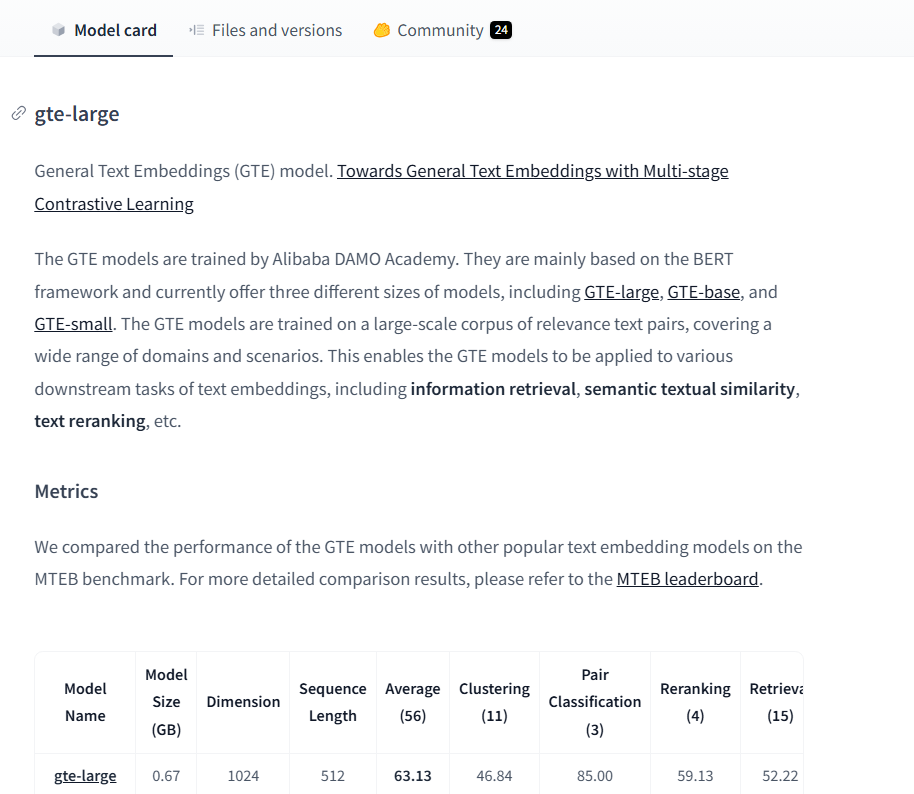

In [53]:
embedding_model = SentenceTransformerEmbeddings(model_name='thenlper/gte-large')

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

### Vector Database

In [54]:
report = 'Medical_Manual'
vectorstore = Chroma.from_documents(
    document_chunks,
    embedding_model,
    collection_name=report
)

### Retriever

The user input is converted to a vector representation using the same model that was used for the context chunks. Then a similarity search is executed against the vectorized chunks in the vector database. Top-$k$ chunks from the search results in this step are then stuffed into the prompt as the context and the LLM is instructed to answer the user query using only the context.

We will now create a retriever that can query an input text and retrieve the top −k  documents that are most relevant from the vector store.

Under the hood, a similarity score is computed between the embedded query and all the chunks in the database
The top  k  chunks with the highest similarity scores are then returned.

In [55]:
retriever = vectorstore.as_retriever(
    search_type='similarity',
    search_kwargs={'k': 6}
)

The given code initializes a **retriever** from the **Chroma vector store** to fetch similar documents based on embeddings. Here's a breakdown:

- `vectorstore.as_retriever(...)`: Converts the **Chroma vector store** into a retriever for querying.
- `search_type='similarity'`: Specifies that retrieval is based on **cosine similarity** (or another similarity metric used by Chroma).
- `search_kwargs={'k': 6}`: Retrieves the **top 6 most similar** documents for a given query.

This allows for **efficient information retrieval**, where the retriever finds the most relevant document chunks based on their **semantic similarity** to a user's query.

### System and User Prompt Template

Prompt designing is a crucial part of designing a RAG based system, it consists mainly of two parts:

- system message: This is the instruction that has to be given to the LLM.
- user message template: This is a message template that contains the context retrieved from the document chunks and the User Query.

In [56]:
qna_system_message = """
You are an assistant whose work is to give answers to questions with repect to a context.
User input will have the context required by you to answer user questions.

This context will begin with the token: ###Context.
The context contains references to specific portions of a document relevant to the user query.

User questions will begin with the token: ###Question.

Strictly answer only using the information provided in the ###Context.
Do not mention anything about the information in ###Context or the question in ###Question in your final answer.

If the answer to ###Question cannot be derived from the ###Context, just respond by saying "I don't know".

Remember that the answer to ###Question might not always be directly present in the information provided in the ###Context.
the answer can be indirectly derived from the information in ###Context.

"""

Note: It is important to specify that the LLM should not attempt to answer the question if the context provided (retrieved from the knowledge base provided) doesn't contain the information required. We don't want the LLM to use the knowledge from its training data and/or hallucinate to share a "seemingly correct" answer.

In [57]:
qna_user_message_template = """
Conider the following ###Context and ###Question
###Context
{context}

###Question
{question}
"""

### Response Function

In [58]:
def generate_rag_response(user_input,k=3,max_tokens=128,temperature=0,top_p=0.95,top_k=50):
    global qna_system_message,qna_user_message_template
    """
    Args:
        user_input: Takes a user input for which the response should be retrieved from the vectorDB.
        lcpp_llm: The LLM to be used for generating the response
    Returns:
        The generated response based on the user query and the context from the knowledge base
    """
    # Retrieve relevant document chunks
    relevant_document_chunks = retriever.get_relevant_documents(query=user_input,k=k)
    context_list = [d.page_content for d in relevant_document_chunks]

    # Combine document chunks into a single context
    context_for_query = ". ".join(context_list)

    user_message = qna_user_message_template.replace('{context}', context_for_query)
    user_message = user_message.replace('{question}', user_input)

    prompt = qna_system_message + '\n' + user_message

    # Generate the response
    try:
        response = lcpp_llm(
                  prompt=prompt,
                  max_tokens=max_tokens,
                  temperature=temperature,
                  top_p=top_p,
                  top_k=top_k
                  )


        # Extract and print the model's response
        response = response['choices'][0]['text'].strip()
    except Exception as e:
        response = f'Sorry, I encountered the following error: \n {e}'

    return response

In [59]:
def RAG(user_input , llm):
    """
    Args:
        user_input: Takes a user input for which the response should be retrieved from the vectorDB.
        llm: The LLM to be used for generating the response
    Returns:
        The generated response based on the user query and the context from the knowledge base
    """
    relevant_document_chunks = retriever.get_relevant_documents(user_input)
    context_list = [d.page_content.replace("\t", " ") for d in relevant_document_chunks]
    context_for_query = ". ".join(context_list)



    # Combine user_prompt and system_message to create the prompt
    prompt = f"""[INST]{qna_system_message}\n
                {'user'}: {qna_user_message_template.format(context=context_for_query, question=user_input)}
                [/INST]"""


    # Quering an LLM
    try:
        response = llm(
                prompt=prompt,
                max_tokens=500,
                temperature=0.4,
                top_p=0.95,
                repeat_penalty=1.2,
                top_k=25,
                stop=['INST'],
                echo=False
                )
        def insert_line_breaks(text, max_words=20):
          words = text.split()
          lines = []
          for i in range(0, len(words), max_words):
            lines.append(' '.join(words[i:i + max_words]))
          return '\n'.join(lines)

        prediction =  response["choices"][0]["text"]

    except Exception as e:
        prediction = f'Sorry, I encountered the following error: \n {e}'

    return  prediction

## Question Answering using RAG

### Query 1: What is the protocol for managing sepsis in a critical care unit?

In [60]:
print(RAG("What is the protocol for managing sepsis in a critical care unit?",lcpp_llm))

Llama.generate: prefix-match hit


  Based on the provided context, I cannot directly answer your question as it requires information beyond what is provided. However, based on the context, I can provide some suggestions that may be helpful:

1. Monitoring: The patient's vital signs and other relevant parameters should be closely monitored to detect any changes or deterioration in their condition. This includes temperature, blood pressure, heart rate, respiratory rate, oxygen saturation, and urine output.
2. Fluid management: Sepsis patients often require aggressive fluid resuscitation to maintain mean arterial pressure (MAP) of at least 65 mmHg. Crystalloid fluids such as normal saline or lactated Ringer's solution should be administered initially, and vasopressors may be added if necessary.
3. Antibiotics: Broad-spectrum antibiotics effective against common causes of sepsis (such as gram-negative bacteria) should be initiated promptly, ideally within the first hour of recognition of septic shock. The choice of antibio

### Query 2: What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?

In [61]:
print(RAG("What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?",lcpp_llm))

Llama.generate: prefix-match hit


  ###Context
The context discusses acute appendicitis, its symptoms, diagnosis, and treatment options.

###Question
What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?

Answer: 
Common symptoms of appendicitis include epigastric or periumbilical pain, nausea, vomiting, anorexia, and tenderness in the right lower quadrant. However, these classic findings may not always be present, and atypical symptoms can occur, especially among elderly patients and pregnant women.

 Appendicitis is primarily a clinical diagnosis, and imaging studies should only be done when necessary to confirm the diagnosis or rule out other conditions. Laparotomy is the most appropriate surgical procedure for treating appendicitis, as it allows for prompt removal of the inflamed appendix and drainage of any abscesses.

In some cases, antibiotics may be used preoperatively to reduce the risk of complications, but they are not

### Query 3: What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?

In [62]:
print(RAG("What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?",lcpp_llm))

Llama.generate: prefix-match hit


  Based on the information provided in the context, the following is an answer to the question:

Sudden patchy hair loss, typically seen as localized bald spots on the scalp, can have various causes. One common cause is alopecia areata, which is an autoimmune disorder that leads to hair loss due to inflammation and destruction of hair follicles. Another possible cause could be telogen effluvium, a condition where there is a significant increase in the number of hair follicles entering the resting phase, leading to excessive hair shedding.

Effective treatments for sudden patchy hair loss include:

1. Corticosteroids: These medications can help reduce inflammation and suppress the immune system, which can slow down or stop hair loss caused by alopecia areata.
2. Topical minoxidil: This medication is applied directly to the scalp and can stimulate hair growth by increasing blood flow and widening the hair follicles.
3. Anthralin: This medication is also topically applied and works by red

### Query 4:  What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?

In [63]:
print(RAG("What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?",lcpp_llm))

Llama.generate: prefix-match hit


  Based on the information provided in the context, there are several treatment recommendations for a person who has sustained a physical injury to brain tissue and is experiencing temporary or permanent impairment of brain function. These include:

1. Supportive care: Preventing systemic complications due to immobilization (e.g., pneumonia, UTI, thromboembolic disease) and providing good nutrition are essential.
2. Physical therapy: Providing physical therapy to prevent limb contractures is crucial in the rehabilitation process.
3. Therapeutic systemic hypothermia: This treatment has not been found helpful in clinical trials, and corticosteroids are not recommended as they have been associated with a worse outcome in recent studies.
4. Seizure management: Prompt treatment of seizures is essential to prevent worsening brain damage and increasing intracranial pressure. Prophylactic anticonvulsants may be considered for patients with significant structural injury or a GCS score < 10.
5. 

### Query 5: What are the necessary precautions and treatment steps for a person who has fractured their leg during a hiking trip, and what should be considered for their care and recovery?

In [64]:
print(RAG("What are the necessary precautions and treatment steps for a person who has fractured their leg during a hiking trip, and what should be considered for their care and recovery?",lcpp_llm))

Llama.generate: prefix-match hit


  Based on the provided context, here is my answer to your question:

To ensure proper care and recovery for an individual with a fractured leg sustained during a hiking trip, it is essential to follow these necessary precautions and treatment steps:

1. Immobilization: The injured limb should be immobilized using a splint or cast to prevent further injury and promote healing. This will help minimize pain, swelling, and the risk of complications such as compartment syndrome.
2. Elevation: Elevate the affected leg above heart level to reduce swelling and promote blood flow.
3. Pain management: Administer appropriate analgesics to manage pain effectively, ensuring that the patient is comfortable and able to rest properly.
4. Wound care: Keep the wound clean and dry, applying a sterile dressing to prevent infection. Monitor for signs of infection, such as redness, swelling, or increased pain.
5. Rest: Encourage the patient to rest and avoid putting weight on the injured leg during the rec

### Fine-tuning

- **`max_tokens`**: This parameter **specifies the maximum number of tokens that the model should generate** in response to the prompt.

- **`temperature`**: This parameter **controls the randomness of the generated response**. A higher temperature value will result in a more random response, while a lower temperature value will result in a more predictable response.

- **`top_p`**: This parameter **controls the diversity of the generated response by establishing a cumulative probability cutoff for token selection**. A higher value of top_p will result in a more diverse response, while a lower value will result in a less diverse response.

- **`repeat_penalty`**: This parameter **controls the penalty for repeating tokens in the generated response**. A higher value of repeat_penalty will result in a lower probability of repeating tokens, while a lower value will result in a higher probability of repeating tokens.

- **`top_k`**: This parameter **controls the maximum number of most-likely next tokens to consider** when generating the response at each step.

- **`stop`**: This parameter is a **list of tokens that are used to dynamically stop response generation** whenever the tokens in the list are encountered.

- **`echo`**: This parameter **controls whether the input (prompt) to the model should be returned** in the model response.

In [90]:
# The  predefined parameters are the default paramters for the original RAG function
def RAG_fine_tune(user_input,llm,max_tokens=500,temperature=0.4,top_p=0.95,top_k=25,repeat_penalty=1.2):
    """
    Args:
        user_input: Takes a user input for which the response should be retrieved from the vectorDB.
        llm: The LLM to be used for generating the response
    Returns:
        The generated response based on the user query and the context from the knowledge base
    """
    relevant_document_chunks = retriever.get_relevant_documents(user_input)
    context_list = [d.page_content.replace("\t", " ") for d in relevant_document_chunks]
    context_for_query = ". ".join(context_list)



    # Combine user_prompt and system_message to create the prompt
    prompt = f"""[INST]{qna_system_message}\n
                {'user'}: {qna_user_message_template.format(context=context_for_query, question=user_input)}
                [/INST]"""


    # Quering an LLM
    try:
        response = llm(
                prompt=prompt,
                max_tokens=max_tokens,
                temperature=temperature,
                top_p=top_p,
                repeat_penalty=1.2,
                top_k=top_k,
                stop=['INST'],
                echo=False
                )
        def insert_line_breaks(text, max_words=20):
          words = text.split()
          lines = []
          for i in range(0, len(words), max_words):
            lines.append(' '.join(words[i:i + max_words]))
          return '\n'.join(lines)

        prediction =  response["choices"][0]["text"]

    except Exception as e:
        prediction = f'Sorry, I encountered the following error: \n {e}'

    return  insert_line_breaks(prediction)

#### Query 1: What is the protocol for managing sepsis in a critical care unit?

In [91]:
print(RAG_fine_tune("What is the protocol for managing sepsis in a critical care unit?",lcpp_llm,max_tokens=1000))

Llama.generate: prefix-match hit


Based on the provided context, there is no direct answer to your question in the given text. However, I can
provide information that may help you find the answer. The management of sepsis in a critical care unit typically involves
early recognition and aggressive treatment with antibiotics, fluid resuscitation, and supportive care. The protocol for managing sepsis in an ICU
may include: 1. Early identification of patients at risk for sepsis using clinical criteria such as SIRS (Systemic Inflammatory Response
Syndrome) or SOFA (Sequential Organ Failure Assessment). 2. Administration of broad-spectrum antibiotics within the first hour of recognition of sepsis,
followed by cultures and adjustment of therapy based on culture results. 3. Aggressive fluid resuscitation with 0.9% saline to maintain
mean arterial pressure (MAP) ≥ 65 mmHg and central venous oxygen saturation (ScvO2) ≥ 70%. 4. Monitoring of vital signs,
including temperature, blood pressure, heart rate, respiratory rate, and oxy

#### Query 2: What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?

In [92]:
print(RAG_fine_tune("What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?",lcpp_llm,temperature=0.9))

Llama.generate: prefix-match hit


###Context The context discusses acute appendicitis, its symptoms, diagnosis, treatment options, and prognosis. It also mentions other conditions affecting the
appendix and their management. ###Question What are the common symptoms for appendicitis, and can it be cured via medicine? If
not, what surgical procedure should be followed to treat it? Answer: The common symptoms of appendicitis include abdominal pain (typically
in the right lower quadrant), nausea, vomiting, fever, loss of appetite, and tender abdomen. While appendicitis can be treated with
antibiotics if caught early, prompt surgical intervention is essential to prevent complications like gangrene or perforation. The recommended surgical procedure
for treating acute appendicitis is a laparoscopic appendectomy or open appendectomy, depending on the severity of the condition and the
surgeon's preference.


#### Query 3: What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?

In [93]:
print(RAG_fine_tune("What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?",
                    lcpp_llm,top_p=0.90))

Llama.generate: prefix-match hit


Based on the context provided, the following is my answer to your question: Sudden patchy hair loss, also known as
alopecia areata, can be treated with topical corticosteroids, oral anti-inflammatory medications, or immunomodulatory drugs. The effectiveness of these treatments varies
depending on the severity and location of the hair loss. In some cases, hair growth may resume spontaneously within a
few months without treatment. Possible causes of sudden patchy hair loss include autoimmune disorders such as alopecia areata, fungal infections
like tinea capitis, bacterial infections like folliculitis, and stress-induced telogen effluvium. A thorough examination by a dermatologist is necessary to
determine the underlying cause of hair loss and develop an appropriate treatment plan. Please note that I cannot provide medical
advice or diagnose conditions based on limited information. If you are experiencing sudden patchy hair loss, it is essential to
consult a qualified healthcare professi

#### Query 4:  What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?

In [94]:
# Increase k=50	- Sample randomly among the top 50 tokens for more randomness, and more diversity
print(RAG_fine_tune("What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?",
                    lcpp_llm,top_k=50))

Llama.generate: prefix-match hit


Based on the information provided in the context, there are no direct answers to your question regarding specific treatments for
a person with a traumatic brain injury. However, supportive care is recommended to prevent systemic complications and ensure good nutrition.
Additionally, physical therapy may be necessary to prevent limb contractures. The Merck Manual of Diagnosis & Therapy recommends the following:
• Preventing systemic complications due to immobilization (eg, pneumonia, UTI, thromboembolic disease) • Providing good nutrition • Preventing pressure ulcers
• Providing physical therapy to prevent limb contractures.


#### Query 5: What are the necessary precautions and treatment steps for a person who has fractured their leg during a hiking trip, and what should be considered for their care and recovery?

In [95]:
#  Increase repeat_penalty = 1.5 - 2.0	 for Strong penalty which forces very diverse output.
print(RAG_fine_tune("What are the necessary precautions and treatment steps for a person who has fractured their leg during a hiking trip, and what should be considered for their care and recovery?",
                    lcpp_llm,repeat_penalty=1.75))

Llama.generate: prefix-match hit


Based on the provided context, here is my answer to your question: To ensure proper care and recovery for someone
with a fractured leg from a hiking trip, it is essential to follow these necessary precautions and treatment steps: 1.
Immobilization: The injured limb should be immobilized using a splint or cast to prevent further injury and promote healing. This
will help reduce pain, swelling, and the risk of complications such as compartment syndrome. 2. Elevation: Elevate the affected leg
above heart level to reduce swelling and promote blood flow. 3. Pain management: Administer appropriate analgesics to manage pain effectively.
This will help the patient rest comfortably, reducing the risk of complications like pressure sores. 4. Monitoring for signs of
infection: Keep an eye out for signs of infection such as redness, swelling, or increased pain around the fracture site.
If any of these symptoms occur, seek medical attention immediately. 5. Follow-up appointments: Schedule regular f

## Output Evaluation

- **Measuring Groundedness** – Ensuring that the generated response is **faithfully derived** from the retrieved documents.  
- **Assessing Relevance** – Checking if the retrieved information directly answers the user’s query.    

For our RAG-based system, I am going to use the **LLM-as-a-Judge** method because other evaluation methods like BLEU and ROGUE score require human reference text as a gold standard reference which we don't have for this case.

LLM judge can determine whether the generated output accurately synthesizes information from the retrieved documents without introducing hallucinations or inconsistencies. It evaluates if the response is contextually relevant and answers the query effectively. Additionally, LLMs can check for logical coherence, ensuring that the generated text flows naturally and maintains consistency throughout.

This method offers several advantages, including scalability and consistency in evaluations, as the LLM can quickly assess large volumes of outputs using predefined criteria. It also reduces the need for human evaluators, enabling faster iteration and improvement of RAG systems. However, challenges include ensuring that the LLM judge itself is factually accurate and unbiased. To address this, LLMs are often fine-tuned or guided using specific evaluation prompts and rubrics to enhance their judgment capabilities.

Overall, using an LLM as a judge enhances the evaluation process in RAG systems by providing a scalable and consistent way to measure relevance, coherence, and factual accuracy.

- We are using the same Llama model for evaluation, so the LLM is rating itself on how well it has performed in the task.

Two variables: *groundedness_rater_system_message*, and *relevance_rater_system_message*, define the evaluation criteria for assessing the quality of the generated answers.

In [71]:
groundedness_rater_system_message = """

You will be presented a ###Question, ###Context used by the AI system and AI generated ###Answer.

Your task is to judge the extent to which the ###Answer is derived from ###Context.

Rate it 1 - if The ###Answer is not derived from the ###Context at all
Rate it 2 - if The ###Answer is derived from the ###Context only to a limited extent
Rate it 3 - if The ###Answer is derived from ###Context to a good extent
Rate it 4 - if The ###Answer is derived from ###Context mostly
Rate it 5 - if The ###Answer is is derived from ###Context completely

Please note: Make sure you give a single overall rating in the range of 1 to 5 along with an overall explanation.

"""

In [72]:
relevance_rater_system_message = """

You will be presented with a ###Question, the ###Context used by the AI system to generate a response, and the AI-generated ###Answer.

Your task is to judge the extent to which the ###Answer is relevant to the ###Question, considering whether it directly addresses the key aspects of the ###Question based on the provided ###Context.

Rate the relevance as follows:
- Rate 1 – The ###Answer is not relevant to the ###Question at all.
- Rate 2 – The ###Answer is only slightly relevant to the **###Question**, missing key aspects.
- Rate 3 – The ###Answer is moderately relevant, addressing some parts of the **###Question** but leaving out important details.
- Rate 4 – The ###Answer is mostly relevant, covering key aspects but with minor gaps.
- Rate 5 – The ###Answer is fully relevant, directly answering all important aspects of the **###Question** with appropriate details from the **###Context**.

Note: Provide a single overall rating in the range of 1 to 5, along with a brief explanation of why you assigned that score.
"""

In [73]:
user_message_template = """
###Question
{question}

###Context
{context}

###Answer
{answer}
"""

In [96]:
def generate_ground_relevance_response(user_input,k=3,max_tokens=128,temperature=0,top_p=0.95,top_k=50):
    global qna_system_message,qna_user_message_template
    # Retrieve relevant document chunks
    relevant_document_chunks = retriever.get_relevant_documents(query=user_input,k=3)
    context_list = [d.page_content for d in relevant_document_chunks]
    context_for_query = ". ".join(context_list)

     #Truncate the context to ensure it fits within the context window
    context_for_query = ". ".join(context_list)
    # Use "cl100k_base" encoding instead of "llama-2-13b-chat"
    context_tokens = tiktoken.get_encoding("cl100k_base").encode(context_for_query)
    if len(context_tokens) > 2048:  # Reserve 2048 tokens for the context
        # Use "cl100k_base" encoding instead of "llama-2-13b-chat"
        context_for_query = tiktoken.get_encoding("cl100k_base").decode(context_tokens[:2048])

    # Combine user_prompt and system_message to create the prompt
    prompt = f"""[INST]{qna_system_message}\n
                {'user'}: {qna_user_message_template.format(context=context_for_query, question=user_input)}
                [/INST]"""

    response = lcpp_llm(
            prompt=prompt,
            max_tokens=max_tokens,
            temperature=temperature,
            top_p=top_p,
            top_k=top_k,
            stop=['INST'],
            echo=False
            )

    answer =  response["choices"][0]["text"]

    # Combine user_prompt and system_message to create the prompt
    groundedness_prompt = f"""[INST]{groundedness_rater_system_message}\n
                {'user'}: {user_message_template.format(context=context_for_query, question=user_input, answer=answer)}
                [/INST]"""

    # Combine user_prompt and system_message to create the prompt
    relevance_prompt = f"""[INST]{relevance_rater_system_message}\n
                {'user'}: {user_message_template.format(context=context_for_query, question=user_input, answer=answer)}
                [/INST]"""

    response_1 = lcpp_llm(
            prompt=groundedness_prompt,
            max_tokens=max_tokens,
            temperature=temperature,
            top_p=top_p,
            top_k=top_k,
            stop=['INST'],
            echo=False
            )

    response_2 = lcpp_llm(
            prompt=relevance_prompt,
            max_tokens=max_tokens,
            temperature=temperature,
            top_p=top_p,
            top_k=top_k,
            stop=['INST'],
            echo=False
            )
    def insert_line_breaks(text, max_words=20):
      words = text.split()
      lines = []
      for i in range(0, len(words), max_words):
          lines.append(' '.join(words[i:i + max_words]))
      return '\n'.join(lines)

    return (
      insert_line_breaks(response_1['choices'][0]['text']),
      insert_line_breaks(response_2['choices'][0]['text'])
  )



#### Query 1: What is the protocol for managing sepsis in a critical care unit?

In [97]:
user_input = "What is the protocol for managing sepsis in a critical care unit?"
ground,rel = generate_ground_relevance_response(user_input,max_tokens=350)

print(ground,end="\n\n")
print(rel)

Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


Based on the provided context, I would rate the answer as 4 (mostly derived from the context). The answer provides
a comprehensive list of the protocols for managing sepsis in a critical care unit, which is consistent with the information
presented in the context. However, some of the specific details and recommendations may not be directly mentioned in the context,
but can be inferred based on the general principles and guidelines provided. Therefore, the answer is mostly derived from the
context, but not completely so.

Based on the provided context, I would rate the answer as follows: The answer provides a comprehensive overview of the
protocol for managing sepsis in a critical care unit, including early recognition, fluid resuscitation, antibiotic therapy, surgical intervention, supportive care,
blood glucose normalization, corticosteroid therapy, and activated protein C. The answer is fully relevant to the question and addresses all
key aspects of sepsis management. However, it do

#### Query 2: What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?

In [98]:
user_input_2 = "What are the common symptoms for appendicitis, and can it be cured via medicine? If not, what surgical procedure should be followed to treat it?"
ground,rel = generate_ground_relevance_response(user_input_2,max_tokens=350)

Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


In [99]:
print(ground,end="\n\n")
print(rel)

Based on the provided context, I would rate the answer as follows: Common symptoms of appendicitis include epigastric or periumbilical
pain, brief nausea and vomiting, anorexia, and tenderness in the right lower quadrant of the abdomen. However, these classic signs
are not always present, and symptoms can vary among individuals, especially in elderly patients and pregnant women. Rating: 4 (out
of 5) The answer is well-informed by the context provided and accurately describes the common symptoms of appendicitis and the
recommended surgical procedure for treating acute appendicitis. However, the answer could be improved by providing more specific information about the
diagnostic criteria for appendicitis and the factors that may influence the choice of surgical procedure (e.g., patient age, severity of
symptoms, presence of complications).

Based on the provided context, I would rate the answer as follows: The answer is fully relevant to the question,
directly addressing all key aspects 

#### Query 3: What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?

In [100]:
user_input_3 = "What are the effective treatments or solutions for addressing sudden patchy hair loss, commonly seen as localized bald spots on the scalp, and what could be the possible causes behind it?"
ground,rel = generate_ground_relevance_response(user_input_3,max_tokens=350)

Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


In [101]:
print(ground,end="\n\n")
print(rel)

Based on the information provided in the context, I would rate the answer as follows: 1. Corticosteroids: 5 (very effective)
2. Minoxidil: 3 (somewhat effective) 3. Finasteride: 4 (moderately effective) 4. Anthralin: 3 (somewhat effective) 5. Immunotherapy: 4 (moderately effective)
The answer provides a comprehensive list of possible treatments for sudden patchy hair loss, including both topical and systemic medications.
However, the explanation could be more detailed and provide specific examples or references to support the effectiveness of each treatment.
Additionally, the answer could benefit from a clearer organization and structure to make it easier to understand and navigate. Overall,
I would rate the answer as 4 out of 5.

Based on the information provided in the context, I would rate the answer as follows: The answer provides a comprehensive
list of effective treatments and solutions for addressing sudden patchy hair loss, including corticosteroids, minoxidil, finasteride, ant

#### Query 4:  What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?

In [102]:
user_input_4 = "What treatments are recommended for a person who has sustained a physical injury to brain tissue, resulting in temporary or permanent impairment of brain function?"
ground,rel = generate_ground_relevance_response(user_input_4,max_tokens=350)

Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


In [103]:
print(ground,end="\n\n")
print(rel)

Based on the information provided in the context, I would rate the answer as 4 (mostly derived from the context).
The answer provides several treatments that may be recommended for a person with a physical injury to brain tissue, which
are supported by the information in the context. However, the answer does not fully address all aspects of the question,
such as the specific treatment plan depending on the severity and location of the injury, and the importance of consulting
a healthcare professional for proper evaluation and treatment. Therefore, I would rate the answer as 4 (mostly derived from the
context) rather than 5 (completely derived from the context).

Based on the information provided in the context, I would rate the relevance of the answer as follows: * Supportive
care: Highly relevant (5/5) - This is a crucial aspect of treating brain injury and is mentioned in the context.
* Physical therapy: Moderately relevant (4/5) - While physical therapy is not specifically mentioned

#### Query 5: What are the necessary precautions and treatment steps for a person who has fractured their leg during a hiking trip, and what should be considered for their care and recovery?

In [104]:
user_input_5 = "What are the necessary precautions and treatment steps for a person who has fractured their leg during a hiking trip, and what should be considered for their care and recovery?"
ground,rel = generate_ground_relevance_response(user_input_5,max_tokens=350)

Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


In [105]:
print(ground,end="\n\n")
print(rel)

Based on the provided context, I would rate the answer as 4 out of 5. The answer provides a comprehensive
list of necessary precautions and treatment steps for a person who has fractured their leg during a hiking trip, including
immobilization, pain management, elevation, cleanliness, monitoring, rest, and follow-up care. The answer also considers important factors such as comfort, hygiene,
nutrition, and rest for the patient's care and recovery. However, to achieve a perfect 5 out of 5 rating, the
answer could benefit from providing more specific time frames for each treatment step and factor, as well as additional information
on how to monitor and address any complications that may arise during the healing process.

Based on the provided context, I would rate the answer as a 4 out of 5 in terms of relevance
to the question. The answer provides a comprehensive list of necessary precautions and treatment steps for a person who has
fractured their leg during a hiking trip, including imm

## Actionable Insights and Business Recommendations



Based on the parameters, no hallucinations were encountered in any of the reponses.

Prompt Engineering tremendously improves better responses by providing specific instructions to the query request as oppose to no instruction.

Retrieval parameter **`k`** is critical as the answer can be spread across multiple contexts.

 **`chunk_overlap`** ensures coherence, especially when context spans across chunks.

**`max_tokens`** depends on query complexity; higher values yield detailed responses, while simple queries result in concise outputs despite large token limits due to prompt design and zero **`temperature`**.

Refine prompt design and temperature settings to control response length and creativity.

Must try to RAG parameters based on specific use cases for optimal performance.

Prioritize groundness  and relevance in evaluations to ensure reliable and contextually accurate outputs.

The Output Evaluator was based on using "cl100k_base" encoding, and results provided feedback as how the scoring was determined indicating the deficiency of the reponse.

Establish a feedback loop to fine-tune parameters, improving performance for diverse query types.



<font size=6 color='blue'>Power Ahead</font>
___